<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Read-the-geotiff-with-rasterio" data-toc-modified-id="Read-the-geotiff-with-rasterio-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Read the geotiff with rasterio</a></span></li><li><span><a href="#Locate-ITALY-on-the-map" data-toc-modified-id="Locate-ITALY-on-the-map-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Locate ITALY on the map</a></span></li><li><span><a href="#Higher-resolution-coastline" data-toc-modified-id="Higher-resolution-coastline-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Higher resolution coastline</a></span><ul class="toc-item"><li><span><a href="#Mapped-image-with-no-coastline" data-toc-modified-id="Mapped-image-with-no-coastline-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Mapped image with no coastline</a></span></li><li><span><a href="#Read-the-shape-file-and-add-the-coastline-to-the-image" data-toc-modified-id="Read-the-shape-file-and-add-the-coastline-to-the-image-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Read the shape file and add the coastline to the image</a></span></li></ul></li></ul></div>

# Introduction

Below we read in the small Vancouver image we wrote out in the image_zoom notebook, and put it on a map with a UTM-10N crs.  We then add a high resolution coastline read from the openstreetmap coastline database.

In [2]:
import rasterio
import a301
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy
from rasterio import windows
from pyproj import transform as proj_transform
from pyproj import Proj
from a301.landsat.toa_reflectance import toa_reflectance_8
import pprint
from a301.utils.data_read import download
from pathlib import Path
from affine import Affine
from a301.landsat.landsat_metadata import landsat_metadata


# Read the geotiff with rasterio

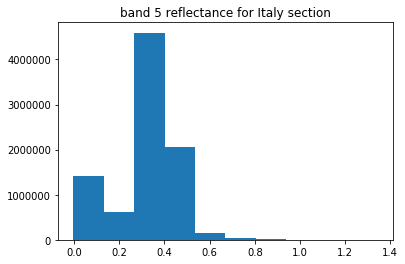

In [3]:
tif_filename=a301.data_dir / Path('italy_small_file.tiff')    
with rasterio.open(str(tif_filename)) as raster:
    affine_transform=raster.affine
    crs=raster.crs
    profile=raster.profile
    refl=raster.read(1)
plt.hist(refl[~np.isnan(refl)].flat)
plt.title('band 5 reflectance for Italy section');
profile

dest_folder=a301.data_dir / Path("landsat8/italy")

In [4]:
print(f"profile: \n{pprint.pformat(profile)}")

profile: 
{'affine': Affine(30.0, 0.0, 349995.0,
       0.0, -30.0, 4626975.0),
 'count': 1,
 'crs': CRS({'init': 'epsg:32633'}),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 2700,
 'interleave': 'band',
 'nodata': 0.0,
 'tiled': False,
 'transform': (349995.0, 30.0, 0.0, 4626975.0, 0.0, -30.0),
 'width': 3300}


# Locate ITALY on the map

We need to project the center of campus from lon/lat to UTM 10N x,y using pyproj.transform

In [10]:
mtl_file=list(dest_folder.glob("*MTL.txt"))[0]
meta_dict=landsat_metadata(mtl_file).__dict__

zone=meta_dict['UTM_ZONE']
ul_x=meta_dict['CORNER_UL_PROJECTION_X_PRODUCT']
# print(list(meta_dict.keys()))
lr_x=meta_dict['CORNER_LR_PROJECTION_X_PRODUCT']
ul_y=meta_dict['CORNER_UL_PROJECTION_Y_PRODUCT']
lr_y=meta_dict['CORNER_LR_PROJECTION_Y_PRODUCT']



def dms2dd(s:str):
    degrees= s[0:2]
    minutes = s[3:5]
    seconds =s[6:8]+s[8]+s[9:11]
    direction=s[-1]
    
    dd = float(degrees) + float(minutes)/60 + float(seconds)/(60*60);
    print(round(dd,5))
    if direction == 'E' or direction == 'N':
        dd *= -1
    return round(dd,6);


# ogr2ogr -skipfailures -f "ESRI Shapefile"  -clipsrc 42.80267 12.20195 40.68867 15.07574   italy_coastlines coastlines-split-4326

clat= dms2dd("""41°45'35.39"N""")  #41.75983
clon=dms2dd("""13°39'53.17"E""")   #13.66477

Scene LC81900312017148LGN00 center time is 2017-05-28 09:46:46
41.75983
13.66477


In [20]:
p_utm = Proj(crs)
p_latlon=Proj(proj='latlong',datum='WGS84')
italy_lon = clon
italy_lat = clat
italy_x, italy_y =proj_transform(p_latlon,p_utm,italy_lon, italy_lat) 
height, width = refl.shape
italy_ul_xy = affine_transform*(0,0)
italy_lr_xy = affine_transform*(width,height)
italy_x,italy_y

(-1890599.4736744436, -5039899.093149414)

# Higher resolution coastline

Here is what Point Grey looks like with the [open street maps](https://automating-gis-processes.github.io/2017/lessons/L7/retrieve-osm-data.html) coastline database.

Optional: If you want to do this for your own image your're going to need to reduce the size of the coastlines database.  There is a good article about different sources for map data on the blog [python4oceanographers](
https://ocefpaf.github.io/python4oceanographers/blog/2015/06/22/osm/).  The basic steps that worked for me:

1. Download the 513 Mbyte shape file of the WGS84 coastline database from [openstreetmap](http://openstreetmapdata.com/data/coastlines)

2. Unzipping the file (it will be about 700 Mbytes) will create a folder called 
   coastlines-split-4326  (4326 is the epsg number for WGS84 lon/lat)
   
3. Figure out the lon/lat coordinates of a bounding box that contains your scene

4. Get a fiona prompt, which provides the command line program ogr2ogr
   (ogr stands for"OpenGIS Simple Features Reference Implementation"). For Vancouver, I used this command (all one line, lons are negative, lats are positive).  Substitute your own lons and lats (note all - signs are single, not double hyphens)
   
       ogr2ogr -skipfailures -f "ESRI Shapefile"  -clipsrc -123.5 49 -123.1 49.4   italy_coastlines coastlines-split-4326
       
   this extracts the segments and writes them to a new  folder called [italy_coastlines](https://github.com/phaustin/a301_code/tree/master/test_data/italy_coastlines) which is less than 140 K and which provides the coastlines below.



## Mapped image with no coastline

Sanity check to make sure we've got the right image

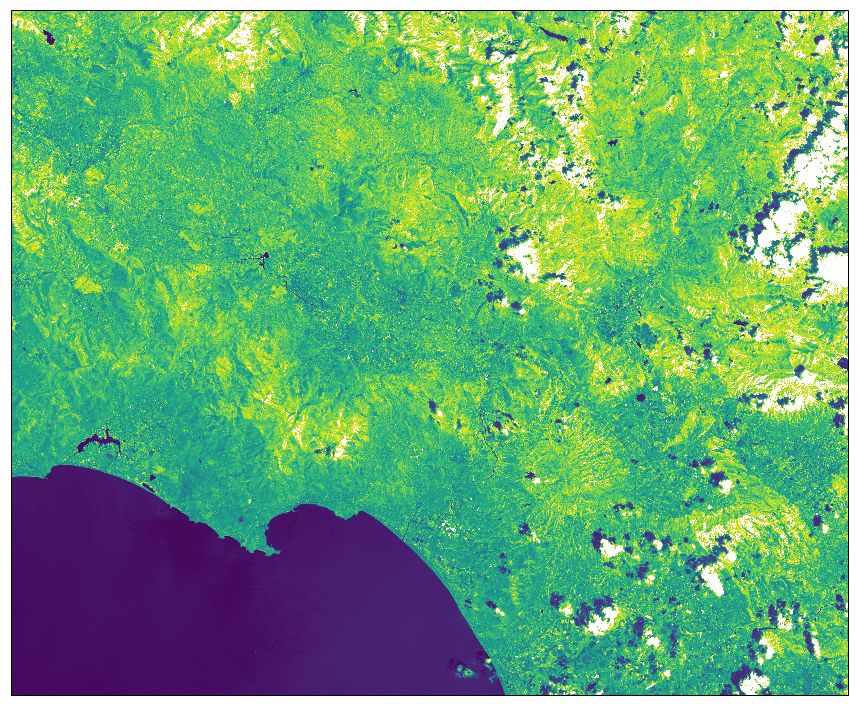

In [16]:
vmin=0.0
vmax=0.5
the_norm=Normalize(vmin=vmin,vmax=vmax,clip=False)
palette='viridis'
pal = plt.get_cmap(palette)
pal.set_bad('0.75') #75% grey for out-of-map cells
pal.set_over('w')  #color cells > vmax red
pal.set_under('k')  #color cells < vmin black
espg= 32633
cartopy_crs=cartopy.crs.epsg(espg)

fig, ax = plt.subplots(1, 1,figsize=[15,25],
                       subplot_kw={'projection': cartopy_crs})
image_extent=[italy_ul_xy[0],italy_lr_xy[0],italy_ul_xy[1],italy_lr_xy[1]]
ax.imshow(refl,origin="lower",
         extent=image_extent,transform=cartopy_crs,
         cmap=pal,norm=the_norm);
ax.plot(italy_x, italy_y,'ro',markersize=25)
ax.set_extent(image_extent,crs=cartopy_crs)

## Read the shape file and add the coastline to the image

Note that PlateCarree is another name for WGS84 datum, simple lat/lon which is the projection of the coastlines-split-4326 shapefile.

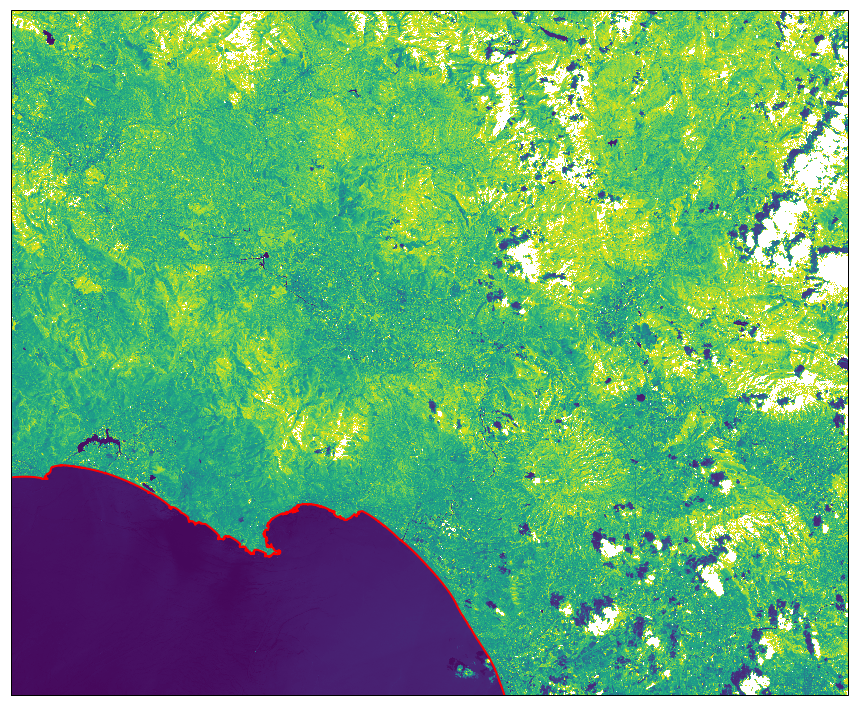

In [17]:
from cartopy.io import shapereader
shape_project=cartopy.crs.PlateCarree()
shp = shapereader.Reader(str(a301.data_dir / 
                             Path("italy_coastlines/lines.shp")))
for record, geometry in zip(shp.records(), shp.geometries()):
    ax.add_geometries([geometry], shape_project,facecolor="none",
                      edgecolor='red',lw=2)
print([geometry])
display(fig)